In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_BN(conv_num=1):
    channel_size = 32
    
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=channel_size, strides=1, 
                      padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv1D (kernel_size=3, filters=channel_size, strides=1, 
                      padding='same')) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=channel_size*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv1D (kernel_size=3, filters=channel_size*(2**int((i+1)/4)), strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    model.add(BatchNormalization())
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 32)         128       
_________________________________________________________________
activation (Activation)      (None, 16000, 32)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 32)         128       
_________________________________________________________________
activation_1 (Activation)    (None, 16000, 32)         0         
_________________________________________________________________
flat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_24 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_20 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_25 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_21 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 32)         3104      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_48 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_49 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 16000, 32)         3104      
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_80 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_72 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_81 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 32)         3104      
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0716 - acc: 0.3782
Epoch 00001: val_loss improved from inf to 1.76027, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_BN_4_conv_checkpoint/001-1.7603.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 2.0716 - acc: 0.3782 - val_loss: 1.7603 - val_acc: 0.4556
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3587 - acc: 0.5879
Epoch 00002: val_loss improved from 1.76027 to 1.41905, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_BN_4_conv_checkpoint/002-1.4190.hdf5
36805/36805 [==============================] - 79s 2ms/sample - loss: 1.3587 - acc: 0.5880 - val_loss: 1.4190 - val_acc: 0.5684
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0879 - acc: 0.6683
Epoch 00003: val_loss did not improve from 1.4190

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0473 - acc: 0.9931
Epoch 00028: val_loss did not improve from 1.16652
36805/36805 [==============================] - 79s 2ms/sample - loss: 0.0473 - acc: 0.9931 - val_loss: 1.6106 - val_acc: 0.6608
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0400 - acc: 0.9952
Epoch 00029: val_loss did not improve from 1.16652
36805/36805 [==============================] - 79s 2ms/sample - loss: 0.0400 - acc: 0.9952 - val_loss: 1.5744 - val_acc: 0.6734
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0388 - acc: 0.9951
Epoch 00030: val_loss did not improve from 1.16652
36805/36805 [==============================] - 79s 2ms/sample - loss: 0.0389 - acc: 0.9951 - val_loss: 1.6209 - val_acc: 0.6618
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0398 - acc: 0.9943
Epoch 00031: val_loss did not improve from 1.16652
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0192 - acc: 0.9977
Epoch 00058: val_loss did not improve from 1.16652
36805/36805 [==============================] - 79s 2ms/sample - loss: 0.0192 - acc: 0.9977 - val_loss: 1.9065 - val_acc: 0.6625

1D_CNN_custom_conv_3_VGG_ch_32_BN_4_conv Model


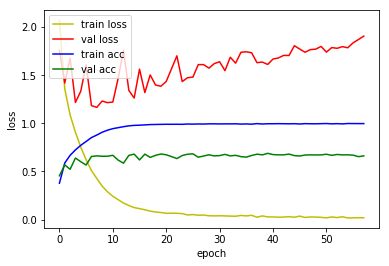

4815/4815 [==============================] - 4s 846us/sample - loss: 1.2832 - acc: 0.6264
Loss: 1.2831656423313225 Accuracy: 0.6263759

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0126 - acc: 0.3914
Epoch 00001: val_loss improved from inf to 1.78512, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_BN_5_conv_checkpoint/001-1.7851.hdf5
36805/36805 [==============================] - 95s 3ms/sample - loss: 2.0127 - acc: 0.3914 - val_loss: 1.7851 - val_acc: 0.4337
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2730 - acc: 0.6146
Epoch 00002: val_loss improved from 1.78512 to 1.20399, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_BN_5_conv_checkpoint/002-1.2040.hdf5
36805/36805 [==============================] - 83s 2ms/sample - loss: 1.2731 - acc: 0.6145 - val_loss: 1.2040 - val_acc: 0.6357
Epoch 3/500
36800/36805 [============================>.] 

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0770 - acc: 0.9851
Epoch 00028: val_loss did not improve from 0.92454
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0772 - acc: 0.9849 - val_loss: 1.1831 - val_acc: 0.7305
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0720 - acc: 0.9868
Epoch 00029: val_loss did not improve from 0.92454
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0723 - acc: 0.9867 - val_loss: 1.1828 - val_acc: 0.7293
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0645 - acc: 0.9881
Epoch 00030: val_loss did not improve from 0.92454
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0648 - acc: 0.9880 - val_loss: 1.1860 - val_acc: 0.7389
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0642 - acc: 0.9883
Epoch 00031: val_loss did not improve from 0.92454
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0309 - acc: 0.9945
Epoch 00058: val_loss did not improve from 0.92454
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0311 - acc: 0.9944 - val_loss: 1.4901 - val_acc: 0.7177
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0392 - acc: 0.9922
Epoch 00059: val_loss did not improve from 0.92454
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0392 - acc: 0.9922 - val_loss: 1.4005 - val_acc: 0.7340

1D_CNN_custom_conv_3_VGG_ch_32_BN_5_conv Model


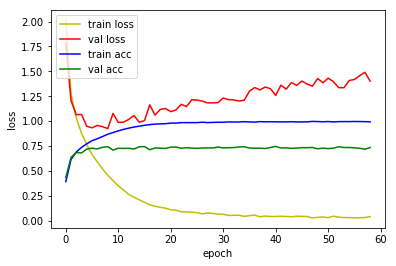

4815/4815 [==============================] - 4s 876us/sample - loss: 0.9920 - acc: 0.7115
Loss: 0.9919993686527478 Accuracy: 0.71152645

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2999 - acc: 0.3086
Epoch 00001: val_loss improved from inf to 1.85221, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_BN_6_conv_checkpoint/001-1.8522.hdf5
36805/36805 [==============================] - 104s 3ms/sample - loss: 2.2998 - acc: 0.3086 - val_loss: 1.8522 - val_acc: 0.4093
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4470 - acc: 0.5596
Epoch 00002: val_loss improved from 1.85221 to 1.23506, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_BN_6_conv_checkpoint/002-1.2351.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.4470 - acc: 0.5597 - val_loss: 1.2351 - val_acc: 0.6254
Epoch 3/500
36800/36805 [============================>.

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0486 - acc: 0.9917
Epoch 00054: val_loss did not improve from 0.56362
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0487 - acc: 0.9916 - val_loss: 0.6723 - val_acc: 0.8400
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0648 - acc: 0.9854
Epoch 00055: val_loss did not improve from 0.56362
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0649 - acc: 0.9853 - val_loss: 0.6335 - val_acc: 0.8595
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0620 - acc: 0.9859
Epoch 00056: val_loss did not improve from 0.56362
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.0620 - acc: 0.9859 - val_loss: 0.6437 - val_acc: 0.8519
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0549 - acc: 0.9883
Epoch 00057: val_loss did not improve from 0.56362
36805/36805 [===========

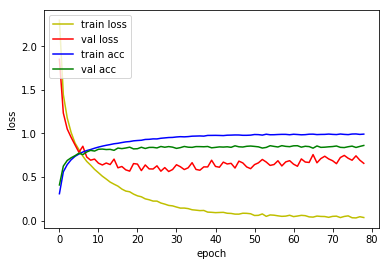

4815/4815 [==============================] - 4s 933us/sample - loss: 0.6275 - acc: 0.8264
Loss: 0.627503177570034 Accuracy: 0.8263759

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4334 - acc: 0.2532
Epoch 00001: val_loss improved from inf to 2.07898, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_BN_7_conv_checkpoint/001-2.0790.hdf5
36805/36805 [==============================] - 114s 3ms/sample - loss: 2.4333 - acc: 0.2532 - val_loss: 2.0790 - val_acc: 0.3371
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5800 - acc: 0.5036
Epoch 00002: val_loss improved from 2.07898 to 1.35390, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_BN_7_conv_checkpoint/002-1.3539.hdf5
36805/36805 [==============================] - 87s 2ms/sample - loss: 1.5800 - acc: 0.5035 - val_loss: 1.3539 - val_acc: 0.5744
Epoch 3/500
36800/36805 [============================>.] 

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1856 - acc: 0.9445
Epoch 00024: val_loss did not improve from 0.30645
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1857 - acc: 0.9445 - val_loss: 0.3454 - val_acc: 0.8963
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1735 - acc: 0.9504
Epoch 00025: val_loss improved from 0.30645 to 0.28748, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_BN_7_conv_checkpoint/025-0.2875.hdf5
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1735 - acc: 0.9504 - val_loss: 0.2875 - val_acc: 0.9171
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1664 - acc: 0.9512
Epoch 00026: val_loss did not improve from 0.28748
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1664 - acc: 0.9512 - val_loss: 0.2935 - val_acc: 0.9147
Epoch 27/500
36800/36805 [============================>.] - ETA: 0

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0681 - acc: 0.9822
Epoch 00053: val_loss did not improve from 0.28143
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0681 - acc: 0.9822 - val_loss: 0.3082 - val_acc: 0.9250
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0514 - acc: 0.9875
Epoch 00054: val_loss did not improve from 0.28143
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0517 - acc: 0.9875 - val_loss: 0.3028 - val_acc: 0.9229
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0585 - acc: 0.9846
Epoch 00055: val_loss did not improve from 0.28143
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0585 - acc: 0.9846 - val_loss: 0.2909 - val_acc: 0.9276
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0435 - acc: 0.9904
Epoch 00056: val_loss did not improve from 0.28143
36805/36805 [===========

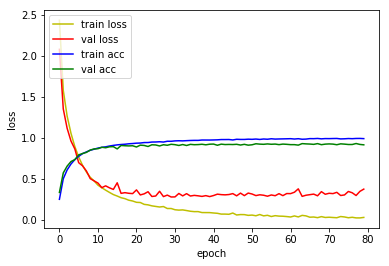

4815/4815 [==============================] - 5s 996us/sample - loss: 0.3580 - acc: 0.8989
Loss: 0.3579766703048104 Accuracy: 0.8988577

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5245 - acc: 0.2364
Epoch 00001: val_loss improved from inf to 2.32138, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_BN_8_conv_checkpoint/001-2.3214.hdf5
36805/36805 [==============================] - 128s 3ms/sample - loss: 2.5244 - acc: 0.2364 - val_loss: 2.3214 - val_acc: 0.2791
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5228 - acc: 0.5326
Epoch 00002: val_loss improved from 2.32138 to 1.19966, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_BN_8_conv_checkpoint/002-1.1997.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.5227 - acc: 0.5326 - val_loss: 1.1997 - val_acc: 0.6252
Epoch 3/500
36800/36805 [============================>.]

36800/36805 [============================>.] - ETA: 0s - loss: 0.0337 - acc: 0.9911
Epoch 00052: val_loss did not improve from 0.19218
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0337 - acc: 0.9910 - val_loss: 0.1959 - val_acc: 0.9460
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0303 - acc: 0.9921
Epoch 00053: val_loss did not improve from 0.19218
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0303 - acc: 0.9921 - val_loss: 0.1990 - val_acc: 0.9474
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0225 - acc: 0.9953
Epoch 00054: val_loss did not improve from 0.19218
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0225 - acc: 0.9953 - val_loss: 0.2016 - val_acc: 0.9502
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0229 - acc: 0.9948
Epoch 00055: val_loss did not improve from 0.19218
36805/36805 [========================

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0262 - acc: 0.9927
Epoch 00082: val_loss did not improve from 0.19218
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0263 - acc: 0.9927 - val_loss: 0.2107 - val_acc: 0.9474
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0217 - acc: 0.9939
Epoch 00083: val_loss did not improve from 0.19218
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0217 - acc: 0.9939 - val_loss: 0.2151 - val_acc: 0.9471
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0097 - acc: 0.9980
Epoch 00084: val_loss did not improve from 0.19218
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0099 - acc: 0.9980 - val_loss: 0.2185 - val_acc: 0.9457
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0233 - acc: 0.9931
Epoch 00085: val_loss did not improve from 0.19218
36805/36805 [===========

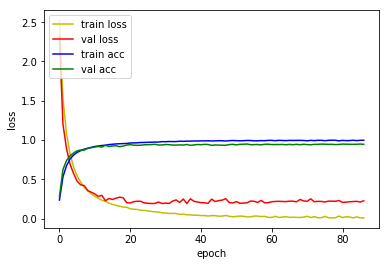

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2376 - acc: 0.9294
Loss: 0.23758113803274286 Accuracy: 0.92938733

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1200 - acc: 0.3480
Epoch 00001: val_loss improved from inf to 1.84708, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_BN_9_conv_checkpoint/001-1.8471.hdf5
36805/36805 [==============================] - 143s 4ms/sample - loss: 2.1202 - acc: 0.3480 - val_loss: 1.8471 - val_acc: 0.4160
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0787 - acc: 0.6611
Epoch 00002: val_loss improved from 1.84708 to 0.79846, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_ch_32_BN_9_conv_checkpoint/002-0.7985.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.0788 - acc: 0.6611 - val_loss: 0.7985 - val_acc: 0.7489
Epoch 3/500
36800/36805 [============================>.]

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0565 - acc: 0.9848
Epoch 00025: val_loss did not improve from 0.19261
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0566 - acc: 0.9848 - val_loss: 0.2113 - val_acc: 0.9366
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0575 - acc: 0.9840
Epoch 00026: val_loss did not improve from 0.19261
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0575 - acc: 0.9840 - val_loss: 0.2420 - val_acc: 0.9308
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0494 - acc: 0.9860
Epoch 00027: val_loss did not improve from 0.19261
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0496 - acc: 0.9859 - val_loss: 0.2341 - val_acc: 0.9329
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0602 - acc: 0.9827
Epoch 00028: val_loss did not improve from 0.19261
36805/36805 [===========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0097 - acc: 0.9981
Epoch 00055: val_loss did not improve from 0.19261
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0097 - acc: 0.9981 - val_loss: 0.2235 - val_acc: 0.9453
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0179 - acc: 0.9955
Epoch 00056: val_loss did not improve from 0.19261
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0179 - acc: 0.9955 - val_loss: 0.2357 - val_acc: 0.9467
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0129 - acc: 0.9969
Epoch 00057: val_loss did not improve from 0.19261
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0129 - acc: 0.9969 - val_loss: 0.2272 - val_acc: 0.9462
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0161 - acc: 0.9956
Epoch 00058: val_loss did not improve from 0.19261
36805/36805 [===========

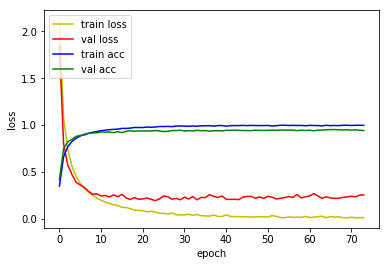

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2672 - acc: 0.9248
Loss: 0.26718826258974776 Accuracy: 0.9248183



In [10]:
base = '1D_CNN_custom_conv_3_VGG_ch_32_BN'

for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [8]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_ch_32_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(4, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_ch_32_BN_4_conv Model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_99 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_90 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_100 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_91 (Activation)   (None, 1600

4815/4815 [==============================] - 4s 823us/sample - loss: 0.9920 - acc: 0.7115
Loss: 0.9919993686527478 Accuracy: 0.71152645

1D_CNN_custom_conv_3_VGG_ch_32_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_108 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_119 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_108 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_109 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_120 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_109 (Activati

4815/4815 [==============================] - 4s 920us/sample - loss: 0.3580 - acc: 0.8989
Loss: 0.3579766703048104 Accuracy: 0.8988577

1D_CNN_custom_conv_3_VGG_ch_32_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_134 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_147 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_134 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_135 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_148 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_135 (Activatio

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2376 - acc: 0.9294
Loss: 0.23758113803274286 Accuracy: 0.92938733

1D_CNN_custom_conv_3_VGG_ch_32_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_150 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_164 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_150 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_151 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_165 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_151 (Activatio

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2672 - acc: 0.9248
Loss: 0.26718826258974776 Accuracy: 0.9248183


In [9]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_ch_32_BN_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_99 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_90 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_100 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_91 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_92 (Conv1D)          

4815/4815 [==============================] - 5s 1ms/sample - loss: 1.5661 - acc: 0.6970
Loss: 1.5660618906823274 Accuracy: 0.6969886

1D_CNN_custom_conv_3_VGG_ch_32_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_108 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_119 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_108 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_109 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_120 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_109 (Activation)

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.4407 - acc: 0.8984
Loss: 0.4406681035785536 Accuracy: 0.8984424

1D_CNN_custom_conv_3_VGG_ch_32_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_134 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_147 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_134 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_135 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_148 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_135 (Activation)

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2616 - acc: 0.9323
Loss: 0.2616408631344822 Accuracy: 0.9322949

1D_CNN_custom_conv_3_VGG_ch_32_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_150 (Conv1D)          (None, 16000, 32)         128       
_________________________________________________________________
batch_normalization_v1_164 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_150 (Activation)  (None, 16000, 32)         0         
_________________________________________________________________
conv1d_151 (Conv1D)          (None, 16000, 32)         3104      
_________________________________________________________________
batch_normalization_v1_165 ( (None, 16000, 32)         128       
_________________________________________________________________
activation_151 (Activation)

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3708 - acc: 0.9192
Loss: 0.37079391523127986 Accuracy: 0.9192108
